# Access the GFEI 2023 data in SDMX format

To run this code, you must first install the packages listed in ``requirements.txt`` in this directory.
Use ``pip install -r requirements.txt``.

In [3]:
import sdmx


## Fetch the data

There are multiple ways to do this, including:

1. Visit the Zenodo record (https://zenodo.org/doi/10.5281/zenodo.10148348) in a web browser and download the files.
2. Use [`sdmx.read_url()`](https://sdmx1.readthedocs.io/en/latest/api.html#sdmx.read_url) with a direct URL to one of the files to fetch and parse the data in one step.
   These URLs typically resemble ``https://zenodo.org/records/10148349/files/structure.xml?download=1``.
3. Use [Pooch](https://www.fatiando.org/pooch/latest/index.html), which we demonstrate below.

First, create a Pooch object that knows about the source location for the data, the names of the individual files, and their [MD5 hashes](https://en.wikipedia.org/wiki/Cryptographic_hash_function#Verifying_the_integrity_of_messages_and_files).
(The hashes are used by Pooch to check that the files downloaded are the same as the ones expected.
If the hash changes, this alerts you that the data, and thus your workflow and results based on the data, may have changed.)

In [4]:
import pooch

p = pooch.create(
    path=pooch.os_cache("gfei-2023"),
    base_url="doi:10.5281/zenodo.10148348",
    registry={
        "data-FP.xml": "md5:bd049c57c062a457cc3bfd6efbc23e3a",
        "data-REG.xml": "md5:bd5a34d6684d596b5922314748055887",
        "data-SEC.xml": "md5:dc178c71fb07c69f73acd794f24c1207",
        "data-WT.xml": "md5:2ffea94198b87e8b6b332bdbc5da0ec7",
        "structure.xml": "md5:fc34509ba76f83dc4dd0177272826322",
    },
)


Now use this object to fetch the structure information and one of the data files.
The `fetch()` method places the downloaded file in a temporary location and returns the path to that location.
It avoids re-downloading the file if it is already up to date.

In [5]:
# structure_message_path = p.fetch("structure.xml")
# data_message_path = p.fetch("data-REG.xml")


## Read the data from files

In [6]:
import sdmx

# Path to the file
# Comment this line to use the path returned by p.fetch(), above
structure_message_path = "structure.xml"

# Read the structure message
sm = sdmx.read_sdmx(structure_message_path)

# Display its contents
sm


<sdmx.StructureMessage>
  <Header>
    source: 
    test: False
  Codelist (3): SEGMENT POWERTRAIN AREA
  ConceptScheme (1): CONCEPTS
  DataflowDefinition (4): SEC WT FP REG
  DataStructureDefinition (4): SEC WT FP REG
  AgencyScheme (1): AGENCIES

This file contains several SDMX data structures:
- An agency scheme with the identifier "AGENCIES",
- A concept scheme and some code lists, and
- 4 data flows and matching data structure definitions.

We will explore these later.
For now, read the data file:

In [7]:
# Comment this line to use the path returned by p.fetch(), above
data_message_path = "data-REG.xml"

# Read the data message
dm = sdmx.read_sdmx(data_message_path, dsd=sm.structure["REG"])

# Display its contents
dm


<sdmx.DataMessage>
  <Header>
    source: 
    test: False
  DataSet (1)
  dataflow: <DataflowDefinition (missing id)>

## Use the data for analysis

Let's select the first (only) data set in this message:

In [8]:
ds = dm.data[0]


…and show some of the observations it contains:ds.obs[:5]

In [9]:
ds.obs[:5]


[Observation(attached_attribute={}, series_key=None, dimension=<Key: AREA=ARE, SEGMENT=large suv, POWERTRAIN=ev, YEAR=2022>, value='170.0', group_keys=set(), value_for=<PrimaryMeasure REG>),
 Observation(attached_attribute={}, series_key=None, dimension=<Key: AREA=ARE, SEGMENT=large suv, POWERTRAIN=hv, YEAR=2022>, value='300.0', group_keys=set(), value_for=<PrimaryMeasure REG>),
 Observation(attached_attribute={}, series_key=None, dimension=<Key: AREA=ARE, SEGMENT=large suv, POWERTRAIN=ice, YEAR=2018>, value='63028.0', group_keys=set(), value_for=<PrimaryMeasure REG>),
 Observation(attached_attribute={}, series_key=None, dimension=<Key: AREA=ARE, SEGMENT=large suv, POWERTRAIN=ice, YEAR=2019>, value='68909.0', group_keys=set(), value_for=<PrimaryMeasure REG>),
 Observation(attached_attribute={}, series_key=None, dimension=<Key: AREA=ARE, SEGMENT=large suv, POWERTRAIN=ice, YEAR=2020>, value='42501.0', group_keys=set(), value_for=<PrimaryMeasure REG>)]

The data can be converted to a [pandas Series](https://pandas.pydata.org/docs/reference/series.html) with a MultiIndex that matches the dimensions of the data flow:

In [10]:
data = sdmx.to_pandas(ds)
data


AREA  SEGMENT       POWERTRAIN  YEAR
ARE   large car     hv          2018     2189.0
                                2019     2988.0
                                2020      561.0
                                2022     4902.0
                    ice         2018    16735.0
                                         ...   
ZAF   unclassified  ice         2018     2568.0
                                2019     3295.0
                                2020      559.0
                                2021     1405.0
                                2022     1769.0
Name: value, Length: 11325, dtype: float64

…and then manipulated, plotted, etc. using standard tools:

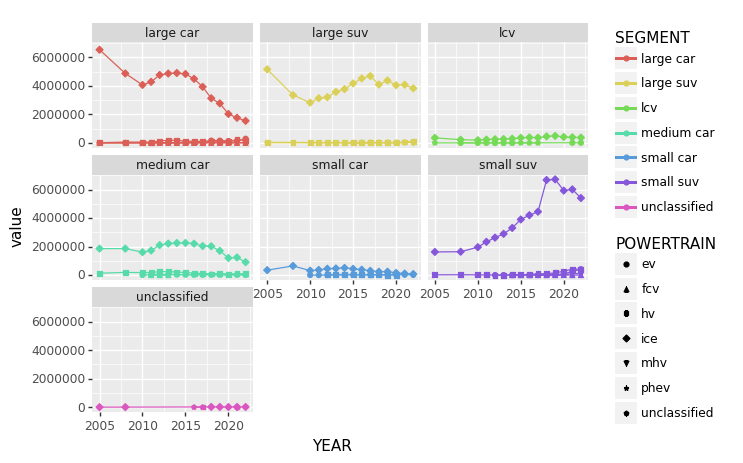

<ggplot: (8780548594221)>

In [11]:
import plotnine as p9

# - Convert to pandas.DataFrame.
# - Convert YEAR labels from strings → integers.
# - Select a subset of data
df = data.reset_index().astype({"YEAR": int}).query("AREA == 'USA'")

# Plot
(
    p9.ggplot(df)
    + p9.aes(x="YEAR", y="value", color="SEGMENT", shape="POWERTRAIN")
    + p9.facet_wrap("SEGMENT")
    + p9.geom_line()
    + p9.geom_point()
)


## Explore structural information and metadata

The SDMX files contain with structural information and metadata that explain the meaning and interpretation of data.
This ensures such information is never separated from the data itself; whenever one has the data, one also has the information necessary to interpret it.

For instance, we can view the description of the data flow:

In [12]:
dfd = sm.dataflow["REG"]
dfd


<DataflowDefinition GFEI_2023:REG(1.0)>

In [13]:
print(dfd.description)


This data contains information on the attributes and fuel economy of newly-sold light-duty vehicles in major automotive markets, as used in the report “Trends in the global vehicle fleet 2023: managing the SUV shift and the EV transition” (https://doi.org/10.7922/G2HM56SV).

The report is the 2023 installment of the Global Fuel Economy Initiative (https://globalfueleconomy.org) which, among other things, tracks progress in the efficiency of the global vehicle fleet.

The data have dimensions AREA, SEGMENT, POWERTRAIN, and YEAR; the second and third are enumerated by the code lists with the same IDs. There are four data flows, one for each MEASURE, and one data set for each flow.
The data were obtained from a set of sources and processed to gain the best possible estimate of global trends in energy consumption for light duty vehicles.
The report provides further information on the upstream sources and methods for data analysis.



We can view the list of codes used for the POWERTRAIN dimension:

In [14]:
cl = sm.codelist["POWERTRAIN"]
cl


<Codelist GFEI_2023:POWERTRAIN(1.0) (7 items)>

…or an individual item in this list:

In [15]:
cl.items.get("hv")


<Code hv: Hybrid vehicle>

Use of these SDMX codes allows the IDs ("hv") used in labelling data to be concise, while the full (multi-lingual) names, descriptions, and arbitrary annotations can be retrieved and displayed as needed.